<a href="https://colab.research.google.com/github/danielrivaldo27/Case-Study-02-Data-Mining-Clustering---Ganjil---2022---Kelompok-G/blob/main/Data_Mining_02_Clustering_Kelompok_G.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Kelompok G *Data Mining* (B)**

1. 2006532891	Abiel Athaya Putra
2. 2006572932	Chrisogonus James Ang Gunadi
3. 2006534890	Daniel Rivaldo Haryanto
4. 2006571160	Dwight J. O. Hutagalung
5. 2006485011	Evan Haryowidyatna
6. 2006570933	Owen Susanto
7. 2006482073	Vito Waradana
8. 2006487326	Wildan Damar Adji

In [1]:
# Importing Modules untuk Notebook ini
import warnings; warnings.simplefilter('ignore')
try:
    import google.colab; IN_COLAB = True
    !pip install umap-learn
    !wget https://raw.githubusercontent.com/taudata-indonesia/eLearning/master/tau_unsup.py
except:
    IN_COLAB = False
    print("Running the code locally, please make sure all the python module versions agree with colab environment and all data/assets downloaded")
import umap, numpy as np, tau_unsup as tau, matplotlib.pyplot as plt, pandas as pd, seaborn as sns
from sklearn import cluster, datasets
from sklearn.metrics import silhouette_score as siluet
from sklearn.metrics.cluster import homogeneity_score as purity
from sklearn.metrics import normalized_mutual_info_score as NMI 

sns.set(style="ticks", color_codes=True)
random_state = 99 #ini buat untuk random_state dan ini penting banget buat kmeans

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 88 kB 3.5 MB/s 
     |████████████████████████████████| 1.1 MB 29.3 MB/s 
  Created wheel for umap-learn: filename=umap_learn-0.5.3-py3-none-any.whl size=82829 sha256=a3d8d23d1587227c0a05de48985dd2a552929a86c81fe1057bb11b027c5974c8
  Stored in directory: /root/.cache/pip/wheels/b3/52/a5/1fd9e3e76a7ab34f134c07469cd6f16e27ef3a37aeff1fe821
  Created wheel for pynndescent: filename=pynndescent-0.5.7-py3-none-any.whl size=54286 sha256=ac039e8f5e3fdd554bf08590ca3862f3234c9072058771c490ca5ab6b8b85250
  Stored in directory: /root/.cache/pip/wheels/7f/2a/f8/7bd5dcec71bd5c669f6f574db3113513696b98f3f9b51f496c
Successfully built umap-learn pynndescent
--2022-10-07 08:25:05--  https://raw.githubusercontent.com/taudata-indonesia/eLearning/master/tau_unsup.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.1

# **Pre-Processing**

Sebelum digunakan, dataset sudah dilakukan *pre-processing* sederhana dari Microsoft Excel secara langsung. Selain itu, kami juga melakukan *data understanding*.

In [2]:
url = 'https://github.com/pigletpiglet/Data-Mining/blob/main/Case-Study-02-MixITup.xlsx?raw=true'
df = pd.read_excel(url)

Beberapa asumsi telah kami lakukan pada data, yakni sebagai berikut.
1.   Pada kolom "Menikah", responden yang mengisi dengan '-' atau mengosongkan, kami asumsikan bahwa responden belum menikah, sehingga untuk nilai-nilai yang '-' atau kosong, kami isi dengan '0' (Tidak Menikah).
2.   Pada kolom "FavFlavor", terdapat data yang bernilai '2' dan '9', sedangkan pada MetaData, kedua nilai tersebut tidak ada. Oleh karena itu, kami mengasumsikan responden yang mengisi '2' dan '9' berarti responden tidak memiliki preferensi rasa.

In [3]:
df["FavFlavor"].replace({0: "Vanilla", 1: "Strawberry",2:"No Preferences", 3: "Cokelat", 4: "BlueBerry", 5: "BubbleGum/Cotton Candy", 6: "Coconut", 7: "Caramel Pecan", 8: "Mix Flavors",9:"No Preferences"}, inplace=True)
df["Menikah"].replace({0: "Belum Menikah", 1: "Menikah"}, inplace=True)
df["Promo"].replace({0: "Tidak Pernah", 1: "Jarang",2:"Sedang", 3: "Sering"}, inplace=True)

In [4]:
df["Jenis Kelamin"] = df["Jenis Kelamin"].astype("category")
df["Menikah"] = df["Menikah"].astype("category")
df["Promo"] = df["Promo"].astype("category")
df["Kota"] = df["Kota"].astype("category")
df["HariFav"] = df["HariFav"].astype("category")
df["FavFlavor"] = df["FavFlavor"].astype("category")

In [5]:
df.dtypes

ID                         int64
Jenis Kelamin           category
Umur                       int64
Pendapatan-per-bulan       int64
skor-pengeluaran           int64
Menikah                 category
Kota                    category
Promo                   category
HariFav                 category
FavFlavor               category
dtype: object

In [6]:
df

,ID,Jenis Kelamin,Umur,Pendapatan-per-bulan,skor-pengeluaran,Menikah,Kota,Promo,HariFav,FavFlavor
0,101,Wanita,49,13114754,52,Menikah,Jakarta,Jarang,Sabtu,No Preferences
1,102,Wanita,32,33606557,86,Menikah,Depok,Jarang,Minggu,Coconut
2,103,Pria,51,15983606,41,Menikah,Jakarta,Sedang,Minggu,Cokelat
3,104,Pria,19,12704918,55,Belum Menikah,Jakarta,Jarang,Rabu,Caramel Pecan
4,105,Wanita,38,20081967,42,Menikah,Jakarta,Sedang,Senin,Mix Flavors
...,...,...,...,...,...,...,...,...,...,...
194,295,Pria,31,4098360,73,Menikah,Depok,Jarang,Senin,Vanilla
195,296,Pria,57,15983606,51,Menikah,Jakarta,Jarang,Minggu,BubbleGum/Cotton Candy
196,297,Wanita,35,43032786,79,Menikah,Depok,Jarang,Senin,Caramel Pecan
197,298,Wanita,23,1229508,94,Menikah,Depok,Tidak Pernah,Selasa,Vanilla


# **EDA (*Exploratory Data Analysis*)**

### **Pengeluaran Paling Besar**

Berikut akan dilihat *swarm plot* untuk melihat toko es krim dengan tingkat pengeluaran dari pelanggan .

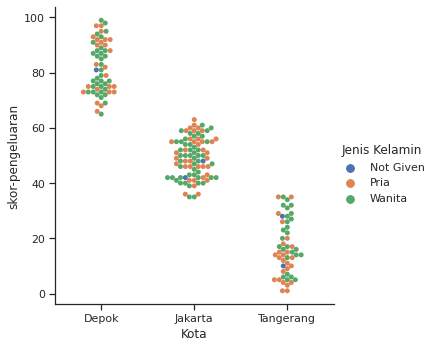

In [7]:
p = sns.catplot(x="Kota", y="skor-pengeluaran", hue="Jenis Kelamin", kind="swarm", data=df)  

Dari *plot* di atas, dapat kita lihat bahwa banyak pelanggan mengeluarkan uangnya untuk membeli es krim Mixitup di Kota Depok. Hal ini berarti jika perusahaan Mixitup ingin memperluas jangkauan pelanggan dan memperbesar perusahaan, kami sangat menyarankan untuk membangun cabang-cabangnya di Kota Depok untuk mendapatkan pangsa pasar yang lebih banyak.

### **Hari Favorit Pelanggan**

Berikut akan dilihat *swarm plot* untuk melihat hari favorit pelanggan membeli es krim di setiap kota.

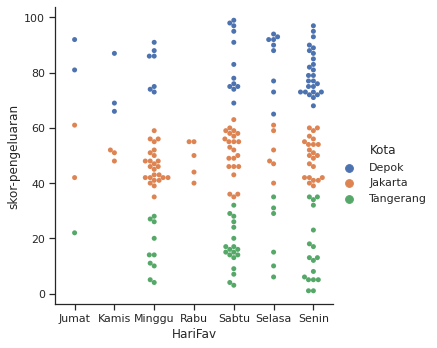

In [8]:
p = sns.catplot(x="HariFav", y="skor-pengeluaran", hue="Kota", kind="swarm", data=df)

Dari *plot* di atas, dapat kita lihat bahwa di Kota Depok, pelanggan Mixitup paling senang membeli es krim di hari Senin. Di kota Jakarta, pelanggan paling suka membeli es krim di hari Senin, Sabtu, dan Minggu, sedangkan di Kota Tangerang, pelanggan paling sering membeli es krim hanya di hari Sabtu saja.

Hal ini menunjukkan bahwa sebaiknya toko-toko jangan tutup di hari-hari yang telah disebutkan di atas sesuai dengan daerah masing-masing dan memberikan promo pada hari sepi pelanggan agar menarik pelanggan membeli Mixitup pada hari-hari itu.

### **Pendapatan per Bulan dari Toko yang Ada di Setiap Kota**

Berikut akan dilihat *swarm plot* dari pendapatan toko  di setiap kota.

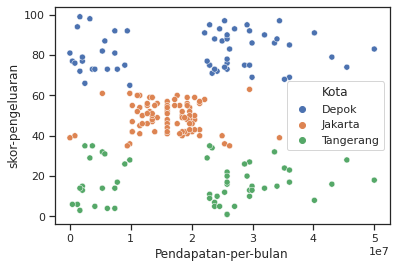

In [9]:
sns.scatterplot(x="Pendapatan-per-bulan",y="skor-pengeluaran",data=df,hue="Kota")

Dari *plot* di atas, dapat kita lihat bahwa tidak ada relasi khusus antara pendapatan perbulan pelanggan dengan skor pengeluaran pelanggan, namun didapatkan bahwa kota Depok merupakan kota dengan Skor Pengeluaran tertinggi. Kami merekomendasikan, untuk sering memberikan promo untuk kota Jakarta dan Tangerang guna meningkatkan kuantitas pembelian di kota tersebut.

### **Hari Favorit x Pengeluaran per Jenis Kelamin**

Berikut akan dilihat bagaimana pengeluaran dari setiap jenis kelamin berdasarkan hari favorit.

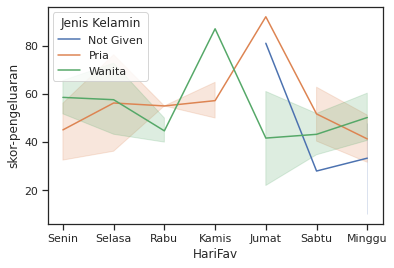

In [10]:
df['HariFav'] = pd.Categorical(df['HariFav'],
                                   categories=['Senin','Selasa','Rabu','Kamis','Jumat','Sabtu','Minggu'],
                                   ordered=True)
sns.lineplot(data=df, x="HariFav", y="skor-pengeluaran", hue="Jenis Kelamin")

Berdasarkan *plot* di atas, dapat kita lihat bahwa untuk jenis kelamin wanita, mereka banyak mengeluarkan uang untuk membeli es krim di hari Kamis, sedangkan untuk jenis kelamin pria jatuh di hari Jumat.

Hal ini dibantu dengan *plot* di bawah ini yang menunjukkan rasa es krim favorit berdasarkan jenis kelamin.

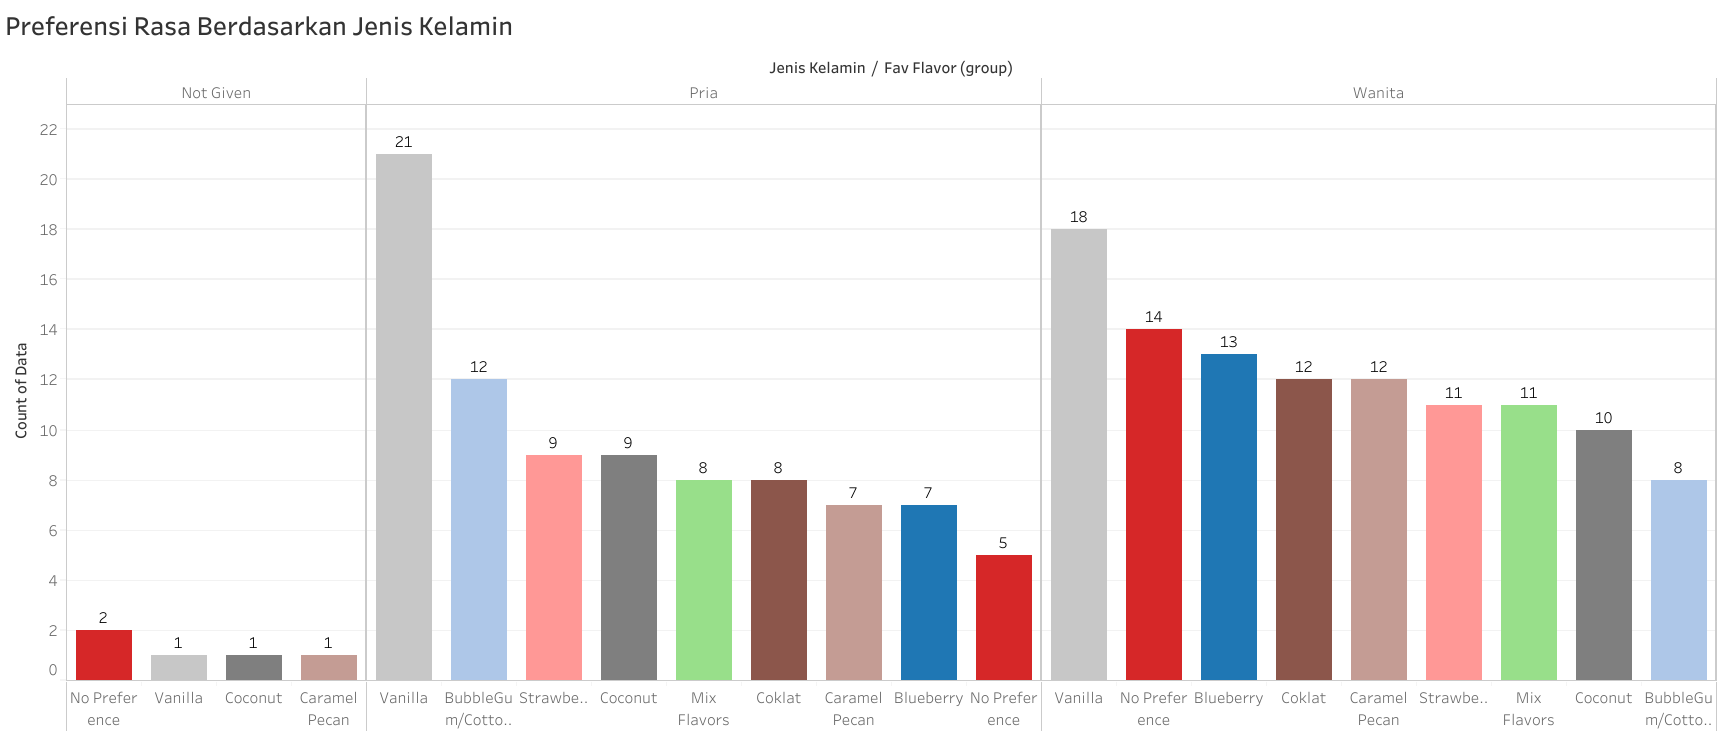

Dari *plot* di atas, dapat dilihat bahwa rasa es krim yang paling disukai baik oleh pria maupun wanita merupakan rasa vanilla.

Dengan informasi bahwa antrian dine-in dan layanan *drive-thru* melebihi kapasitas pelayanan, kami memberikan rekomendasi untuk menambah stok es krim rasa vanilla agar memenuhi permintaan pelanggan.

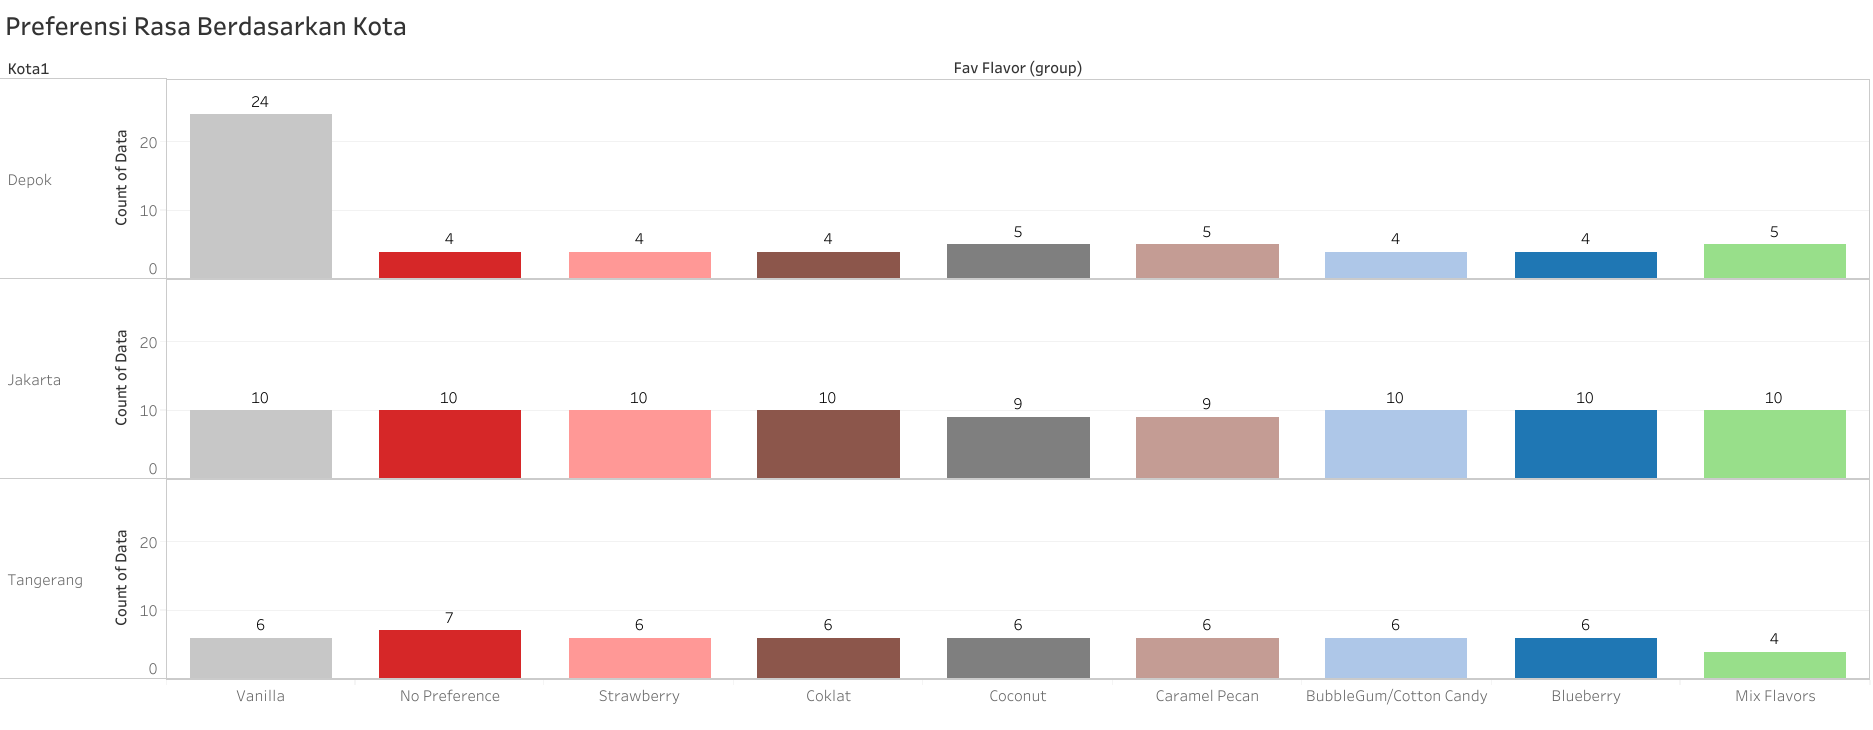

# ***Clustering***

In [11]:
X = df[['Pendapatan-per-bulan','Umur','skor-pengeluaran']]#.values
C = df['Kota']#.values

Text(0.5, 1.0, 'Elbow curve')

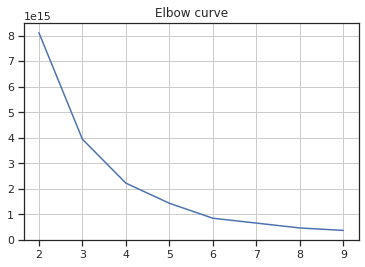

In [12]:
distorsions, k1, kN = [], 2, 10
for k in range(k1, kN):
    kmeans = cluster.KMeans(n_clusters=k).fit(X)
    distorsions.append(kmeans.inertia_)

plt.plot(range(k1, kN), distorsions); plt.grid(True)
plt.title('Elbow curve')


Berdasarkan *elbow method* di atas, dapat kita lihat bahwa terdapat beberapa kemungkinan jumlah k, yakni 3, 4, dan 5.

### ***Clustering* dengan *k-Means* dengan k = 4**

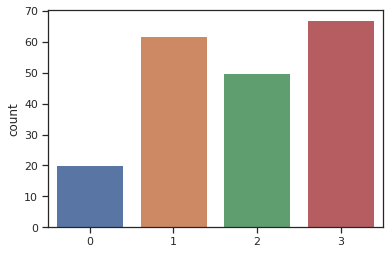

In [13]:
k = 4
km = cluster.KMeans(n_clusters=k, init='random', random_state = 0)
km.fit(X)
# Hasil clusteringnya
C_km = km.predict(X)
p= sns.countplot(x=C_km)

### ***Clustering* dengan *k-Means++* dengan k = 4**

array([3, 2, 3, 3, 3, 0, 0, 1, 3, 3], dtype=int32)

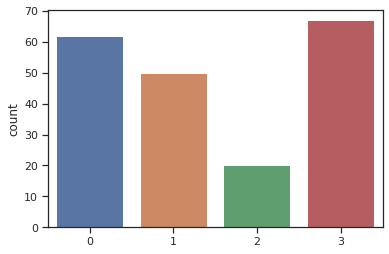

In [14]:
k = 4
kmPP1 = cluster.KMeans(n_clusters=k, init='k-means++', max_iter=300, tol=0.0001, random_state = random_state)
kmPP1.fit(X)
C_kmpp1 = kmPP1.predict(X)

sns.countplot(x=C_kmpp1)
C_kmpp1[:10]

### ***Clustering* dengan *k-Means* dengan k = 3**

array([1, 2, 0, 1, 0, 2, 0, 1, 1, 0], dtype=int32)

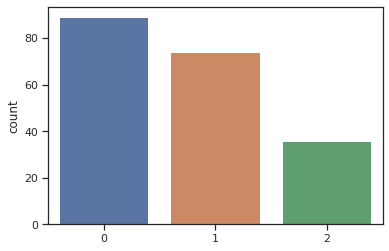

In [15]:
k = 3
kmPP2 = cluster.KMeans(n_clusters=k, init='k-means++', max_iter=300, tol=0.0001, random_state = random_state)
kmPP2.fit(X)
C_kmpp2 = kmPP2.predict(X)

sns.countplot(x=C_kmpp2)
C_kmpp2[:10]

### ***Clustering* dengan *k-Means* dengan k = 5**

array([1, 0, 4, 1, 4, 2, 4, 3, 1, 4], dtype=int32)

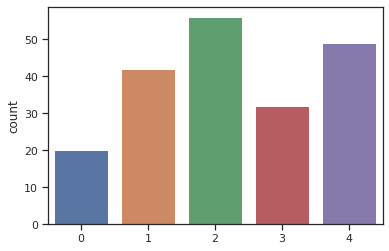

In [16]:
k = 5
kmPP3 = cluster.KMeans(n_clusters=k, init='k-means++', max_iter=300, tol=0.0001, random_state = random_state)
kmPP3.fit(X)
C_kmpp3 = kmPP3.predict(X)

sns.countplot(x=C_kmpp3)
C_kmpp3[:10]

### ***Clustering* dengan *Mini Batch k-Means* dengan k = 3**

array([2, 0, 2, 2, 2, 0, 2, 1, 2, 2], dtype=int32)

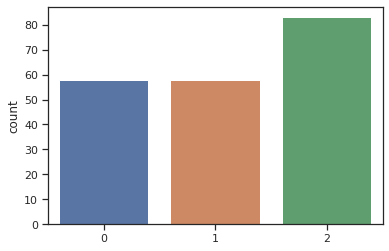

In [17]:
k = 3
# MiniBatch k-Means http://scikit-learn.org/stable/modules/generated/sklearn.cluster.MiniBatchKMeans.html
mbkm1 = cluster.MiniBatchKMeans(n_clusters=k, init='random', \
                               max_iter=300, tol=0.0001, batch_size = 100, random_state = random_state) 
mbkm1.fit(X)
C_mbkm1 = mbkm1.predict(X)
sns.countplot(x=C_mbkm1)
C_mbkm1[:10]

### ***Clustering* dengan *Mini Batch k-Means* dengan k = 4**

array([2, 1, 2, 2, 2, 0, 0, 3, 2, 2], dtype=int32)

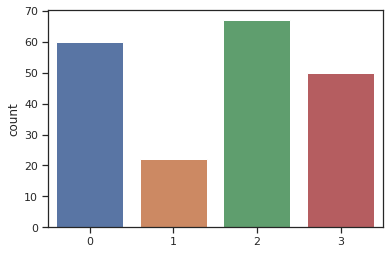

In [18]:
k = 4
# MiniBatch k-Means http://scikit-learn.org/stable/modules/generated/sklearn.cluster.MiniBatchKMeans.html
mbkm2 = cluster.MiniBatchKMeans(n_clusters=k, init='random', \
                               max_iter=300, tol=0.0001, batch_size = 100, random_state = random_state) 
mbkm2.fit(X)
C_mbkm2 = mbkm2.predict(X)
sns.countplot(x=C_mbkm2)
C_mbkm2[:10]

### ***Clustering* dengan *Mini Batch k-Means* dengan k = 5**

array([2, 3, 2, 2, 1, 3, 1, 0, 2, 1], dtype=int32)

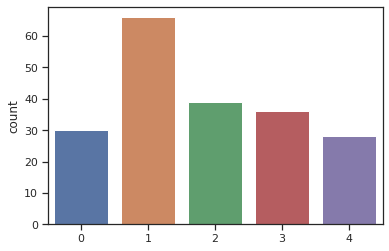

In [19]:
k = 5
# MiniBatch k-Means http://scikit-learn.org/stable/modules/generated/sklearn.cluster.MiniBatchKMeans.html
mbkm3 = cluster.MiniBatchKMeans(n_clusters=k, init='random', \
                               max_iter=300, tol=0.0001, batch_size = 100, random_state = random_state) 
mbkm3.fit(X)
C_mbkm3 = mbkm3.predict(X)
sns.countplot(x=C_mbkm3)
C_mbkm3[:10]

### **Melihat *silhouette coefficient* dari setiap metode *clustering* dengan beberapa nilai k yang didapat dari *elbow method***

In [20]:
#Evaluasi : Internal . Contoh Silouette Coefficient ==> warning hanya cocok untuk k-means (centroid-based clustering)
Hasil_Clustering = [C_km, C_kmpp1, C_kmpp2, C_kmpp3, C_mbkm1, C_mbkm2, C_mbkm3 ]
for res in Hasil_Clustering:
    print(siluet(X,res), end=', ')

0.5578580634226354, 0.5578580634226354, 0.5626775193615058, 0.582186928965082, 0.5188050250446935, 0.5575270692898815, 0.5125225907518384, 

Dari *output* di atas, dapat kita lihat bahwa metode terbaik adalah ***MiniBatch k-Means* dengan k = 3** karena dengan k = 3 sudah cukup mewakili relasi dari variabel x dan y.

### **Melihat *histogram* dari jumlah *cluster* yang telah kita dapatkan.**



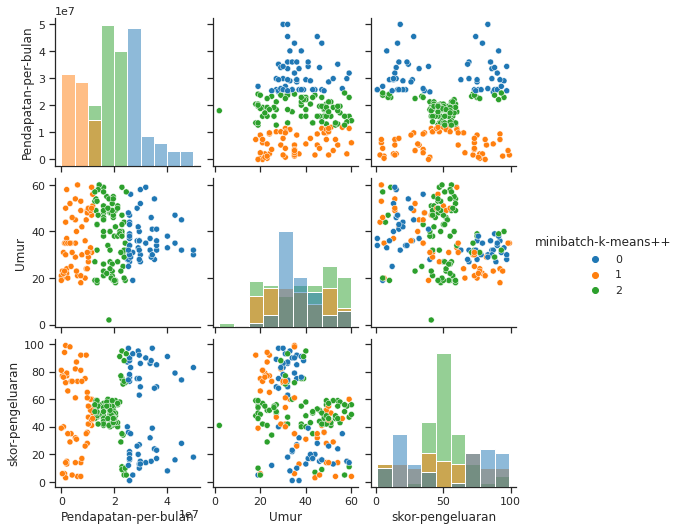

In [21]:
df['minibatch-k-means++'] = C_mbkm1
g = sns.pairplot(df[['Pendapatan-per-bulan','Umur','skor-pengeluaran','minibatch-k-means++']], \
                 hue="minibatch-k-means++", diag_kind="hist", palette="tab10")

Dari *plot* di atas, kita ingin melihat bagaimana hubungan antara variabel-variabel 'skor-pengeluaran', 'Umur', dan 'Pendapatan-per-bulan' dengan k = 3 (didapat dari proses sebelumnya).

### **Melihat orang yang paling *profitable* berdasarkan hasil *clustering* kami.**

In [22]:
gigachad = df.loc[df['minibatch-k-means++']==0]
gigachad

,ID,Jenis Kelamin,Umur,Pendapatan-per-bulan,skor-pengeluaran,Menikah,Kota,Promo,HariFav,FavFlavor,minibatch-k-means++
1,102,Wanita,32,33606557,86,Menikah,Depok,Jarang,Minggu,Coconut,0
5,106,Wanita,33,29098360,95,Menikah,Depok,Tidak Pernah,Senin,Vanilla,0
11,112,Pria,36,29508196,92,Menikah,Depok,Tidak Pernah,Jumat,Vanilla,0
12,113,Pria,46,34016393,15,Menikah,Tangerang,Sering,Selasa,Caramel Pecan,0
16,117,Wanita,47,25819672,16,Menikah,Tangerang,Sering,Sabtu,Strawberry,0
17,118,Wanita,32,25000000,87,Menikah,Depok,Jarang,Kamis,Mix Flavors,0
29,130,Wanita,30,25819672,73,Menikah,Depok,Jarang,Selasa,Mix Flavors,0
31,132,Pria,27,29918032,69,Menikah,Depok,Jarang,Kamis,Vanilla,0
32,133,Wanita,36,28688524,75,Menikah,Depok,Jarang,Minggu,Coconut,0
35,136,Pria,19,27049180,5,Belum Menikah,Tangerang,Sering,Senin,BubbleGum/Cotton Candy,0


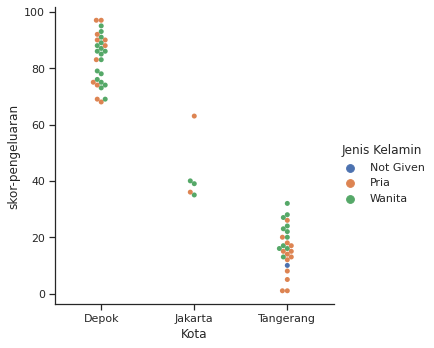

In [23]:
p = sns.catplot(x="Kota", y="skor-pengeluaran", hue="Jenis Kelamin", kind="swarm", data=gigachad)  

Dari *output* di atas, dapat kita lihat bahwa dari kelompok pelanggan yang *profitable*, pelanggan terbanyak adalah wanita. 

Selain itu, dapat kita lihat juga bahwa di kota Jakarta hanya terdapat sedikit orang yang *profitable*. Namun, berdasarkan data dari BPS (https://www.bps.go.id/indikator/indikator/view_data_pub/0000/api_pub/WVJ1ekI3NzNYeFNqVDdaUjRoWHVjQT09/da_13/1), kita tahu bahwa pengeluaran pelanggan di kota Jakarta untuk makanan cukup besar (di sini kita mengasumsikan bahwa toko es krim di kota Jakarta belum ter-*expose*). 


Jadi, kami merekomendasikan kepada Mixitup untuk melakukan *marketing* dalam skala besar. Berdasarkan sumber https://www.visualcapitalist.com/29-psychological-tricks-to-make-you-buy-more/, terdapat banyak cara yang dapat dilakukan untuk memperbesar *marketing*.

Kita tahu bahwa sekarang kita sudah hidup di zaman digital yang sangat maju, sehingga promosi dengan menggunakan *poster*/*banner*/baliho sudah tidak relevan. Malah, yang kita lihat sekarang ini, banyak promosi dilakukan melalui media sosial oleh *influencer*. 

Oleh karena itu, ada beberapa trik promosi untuk daerah kota Jakarta, yakni
1.   Membayar *influencer* untuk bisa memperbesar *marketing*.
2.   Jika ingin memberikan promo, kami menyarankan untuk tidak memberikan promo dalam bentuk diskon, tetapi memberikan promo dalam bentuk **buy 2 get 1** atau **beli 2 gratis 1** atau bonus lainnya agar masyarakat di kota Jakarta bisa mengeluarkan uang yang lebih untuk membeli es krim dan cabang dari es krim Mixitup bisa ter-*expose* ke lebih banyak orang.

# ***Future Endeavour* (Prospek Masa Depan)**

Berikut beberapa saran yang kami bisa berikan untuk meningkatkan keuntungan penjualan ataupun untuk membantu perusahaan Mixitup untuk menentukan lokasi/*store* selanjutnya.

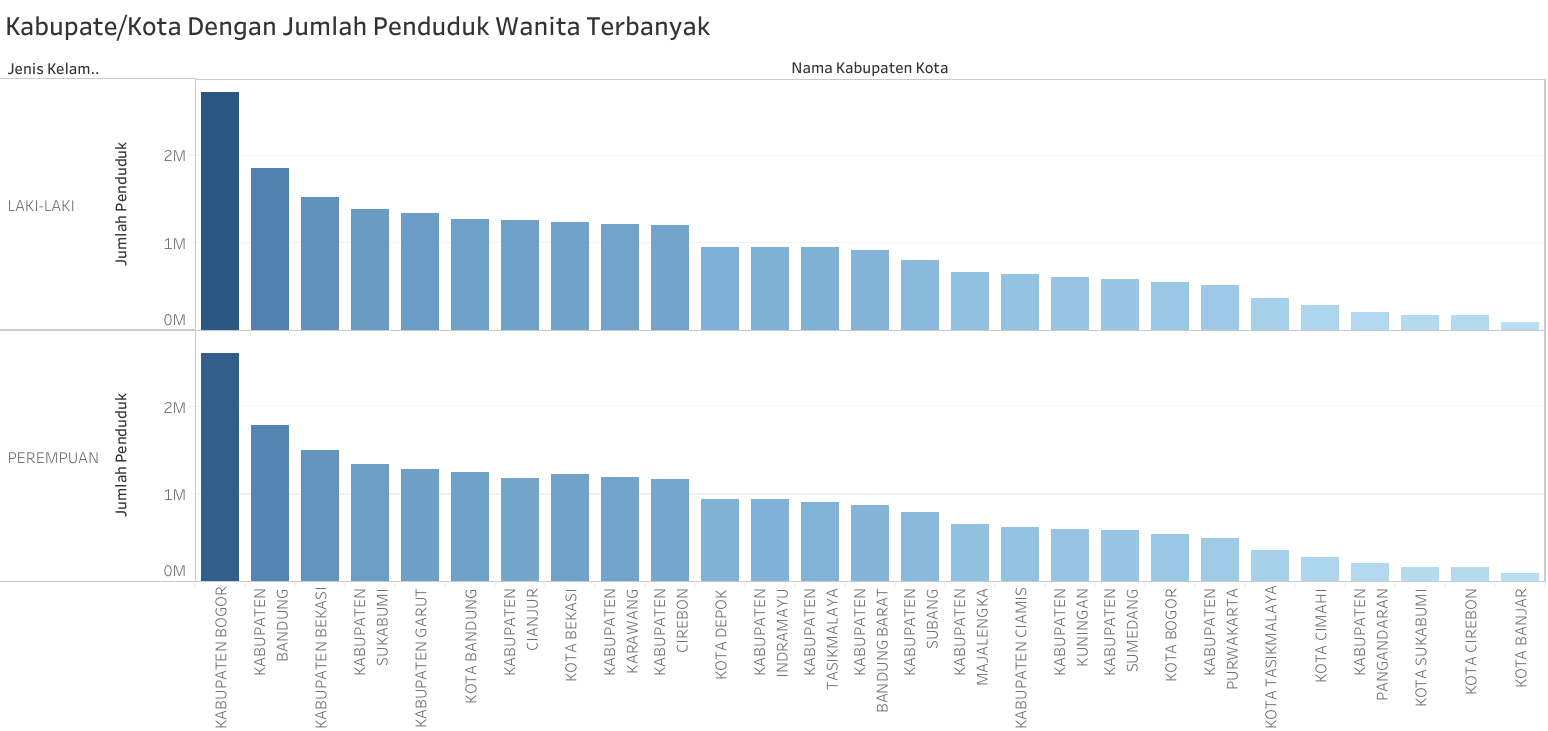

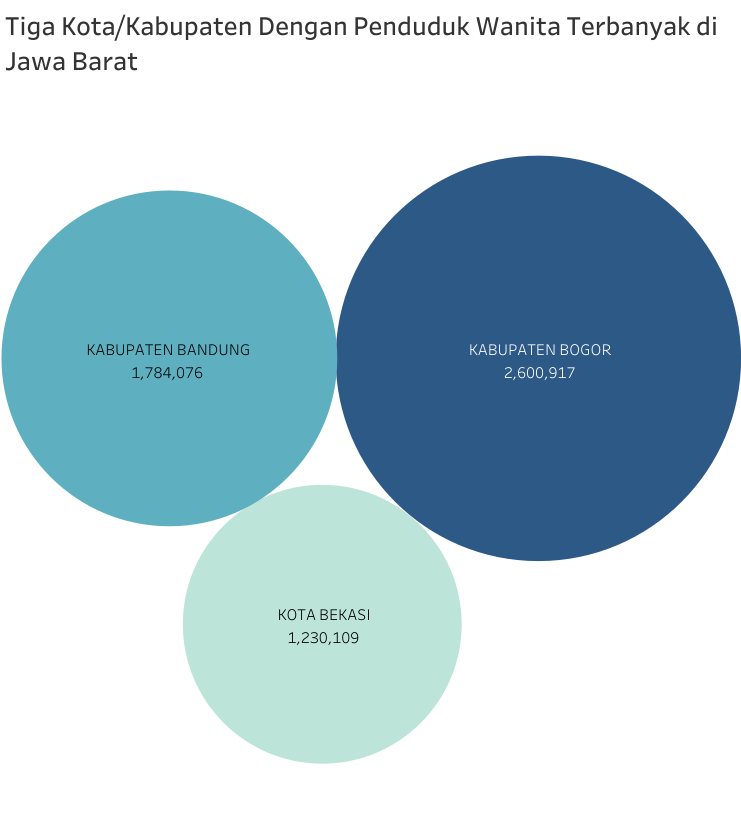

Berdasarkan kedua *plot* di atas, dapat kita simpulkan bahwa kota dengan wanita terbanyak dengan *market* terbanyak adalah di daerah Bandung.

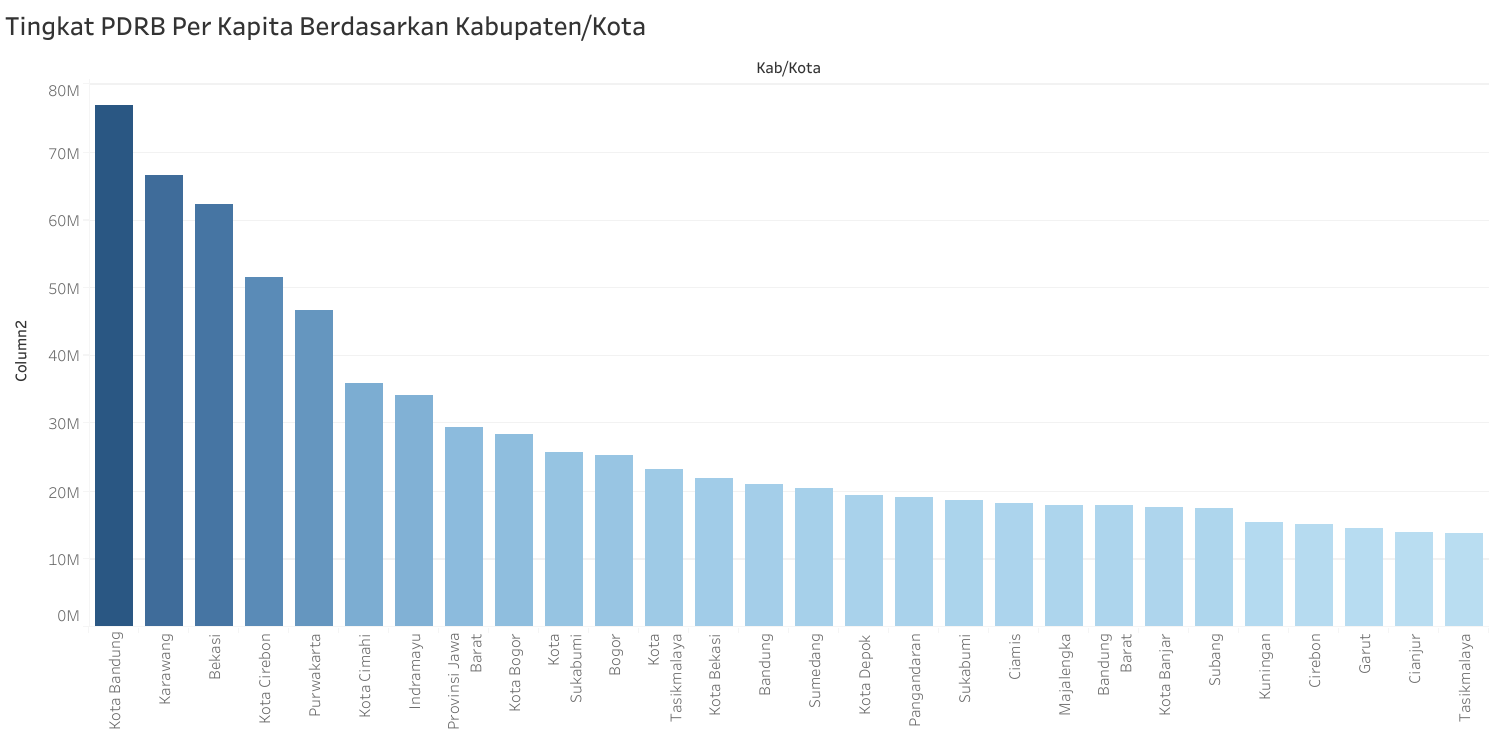

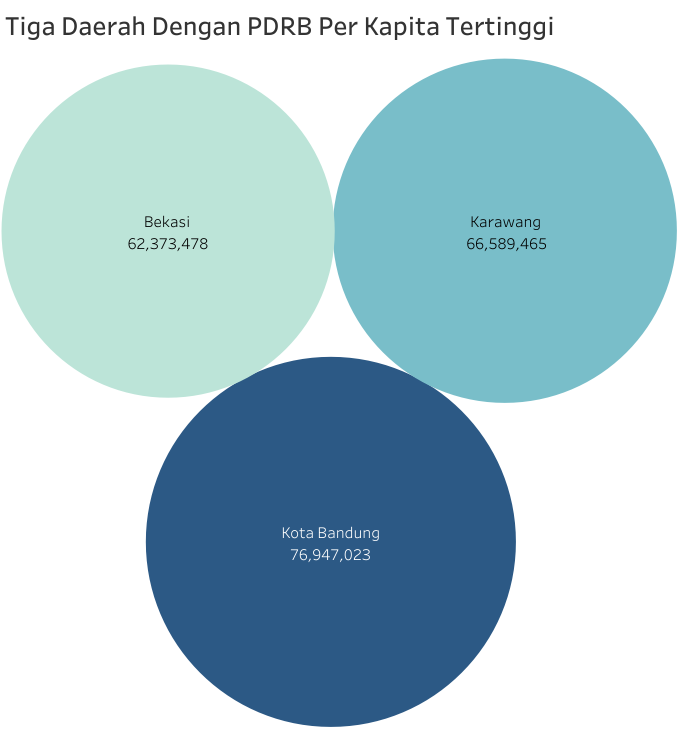

Dari *plo-plot* di atas, dapat kita lihat pula bahwa ternyata kota Bandung memiliki pendapatan tertinggi dari antara kota-kota lain di Jawa Barat.

Maka, kami menyarankan **kota Bandung sebagai target ekspansi dari cabang toko es krim Mixitup**.